# **Optimizing a Loss Function with PyTorch: Gradient Descent for Linear Regression**  

## **Real-World Motivation: Predicting House Prices** 🏡  

Imagine you are a **real estate analyst**, and you want to predict house prices based on the square footage of homes. If we can build an accurate **linear model**, we can help homeowners estimate the value of their properties and guide potential buyers in making informed decisions.  

To achieve this, we'll use **linear regression**, which models the relationship between **house size (\(x\))** and **house price (\(y\))** as follows:  

\[
y = w x + b
\]

where:  
- \( w \) is the **weight (slope)**, determining how much the price increases per square foot.  
- \( b \) is the **bias (intercept)**, representing the base price of a house.  

To **train** our model, we need to **optimize a loss function** that measures how far off our predictions are from actual prices. We'll use **Mean Squared Error (MSE)** and optimize it using **gradient descent**, but this time leveraging PyTorch’s **automatic differentiation** (`autograd`).  

Let’s get started! 🚀  

---

## **1️⃣ Import Necessary Libraries**  

To begin, you need to import the required libraries. PyTorch will be used for model definition and optimization, NumPy for numerical operations, and Matplotlib for visualization.  

In case you are using pytorch for the first time, you'll need to create a specific environment to run your code and install necessary library (pytorch may be picky about its dependencies so creating a dedicated environment avoids trouble).

```shell
conda create -n pytorch python=3.10
conda activate pytorch
pip install torch torchvision matplotlib
```


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## **2️⃣ Create a Dataset (House Size vs. Price)**  

Now, let's define a simple dataset that represents **house sizes in square feet** (e.g.: 800, 900, 1200, 1500, 1700, 2000) and their corresponding **prices in thousands of dollars** (e.g.: 160, 180, 220, 280, 310, 370). Create two tensors, one for house sizes and one for house prices. Ensure both tensors are of type `float32` and have the correct shape using `.reshape(-1,1)`.  

<Note type="tip" title="torch.tensor">
For this task you will use `torch.tensor`:
A tensor is a multi-dimensional array that can store numerical data. PyTorch’s torch.tensor module provides a flexible way to create and manipulate tensors efficiently. You may create tensors from lists:
```python
# Creating a tensor from a list
x = torch.tensor([1.0, 2.0, 3.0])
print(x)
```
</Note>

You'll discover later that tensors have a wonderful property, they allow for auto-differentiation (meaning you'll be able to calculate gradients easily if you make calculations with tensors, trust me it's amazing).

In [3]:
# Simulated dataset: House size (sq ft) and corresponding price ($1000s)
house_size = torch.tensor([800, 900, 1200, 1500, 1700, 2000], dtype=torch.float32).reshape(-1,1)
house_price = torch.tensor([160, 180, 220, 280, 310, 370], dtype=torch.float32).reshape(-1,1)

print(house_size)
print(house_price)

tensor([[ 800.],
        [ 900.],
        [1200.],
        [1500.],
        [1700.],
        [2000.]])
tensor([[160.],
        [180.],
        [220.],
        [280.],
        [310.],
        [370.]])


## **3️⃣ Define the Linear Regression Model**  

Define a `LinearRegressionModel` class that inherits from `nn.Module`. Inside this class, create two trainable parameters: `w` for the weight (slope) and `b` for the bias (intercept). These should be defined as `nn.Parameter()` with random initialization and `requires_grad=True` to allow PyTorch to track their gradients.  

Then, define a `forward()` method that takes an input `x` and returns the predicted value using the equation **\(y = wx + b\)**.  

<Note type="tip" title="nn.Module">
The torch.nn.Module class is the foundation for building neural networks in PyTorch. It provides a structured way to define and organize layers (in neural networks, we'll find out more later), parameters, and computations for models.
</Note>

<Note type="tip" title="nn.Parameter">
A regular tensor in PyTorch is not automatically considered a model parameter. If you define a tensor inside an nn.Module but don’t explicitly register it as a parameter, it won’t be optimized during training.

By wrapping a tensor with nn.Parameter, PyTorch adds it to the list of model parameters, making it visible to optimizers like SGD or Adam.
</Note>

In [4]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, requires_grad=True))  # Weight (slope)
        self.b = nn.Parameter(torch.randn(1, requires_grad=True))  # Bias (intercept)
    
    def forward(self, x):
        return self.w * x + self.b  # y = wx + b

Now, create an instance of the `LinearRegressionModel` class and store it in a variable called `model`. 

In [5]:
# Initialize model
model = LinearRegressionModel()

## **4️⃣ Define the Loss Function (Mean Squared Error)**  

Define a function called `mse()` that calculates the **Mean Squared Error (MSE)** between the predicted values and the actual values. This function should take two arguments: `y_pred` (predictions) and `y_true` (actual values). Inside the function, return the mean of the squared differences between `y_pred` and `y_true`.  

In [8]:
# Mean Squared Error Loss
def mse(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean()


## **5️⃣ Use PyTorch’s Autograd to Compute Gradients**  

Perform a **forward pass** by passing `house_size` to `model` and storing the predictions in `y_pred`. Then, compute the **loss** by calling the `mse()` function with `y_pred` and `house_price` as arguments.  

After computing the loss, call `.backward()` on the loss to perform **automatic differentiation**. Finally, print the computed gradients for `w` and `b` using `.grad.item()`.  

<Note type="tip" title=".backward()">
The `.backward()` is associated with tensor objects. It works in conjunction with `nn.Parameter`, and calculates the gradient of a tensor according to the elements indicated as parameters. Remember, the gradient of the loss function is a vector where each component is the partial derivative of the loss function according to each parameter. We need to flag each model parameter so that backward calculates the gradient component for each of them and ONLY them.
</Note>

In [9]:
# Forward pass: Compute initial predictions
y_pred = model(house_size)

# Compute loss
loss = mse(y_pred, house_price)

# Perform backpropagation
loss.backward()

# Display computed gradients
print(f"Gradient of w: {model.w.grad.item()}")
print(f"Gradient of b: {model.b.grad.item()}")

Gradient of w: 1188421.625
Gradient of b: 796.3521118164062


## **6️⃣ Perform Gradient Descent Optimization**  

Now, define a **learning rate** and the number of **epochs** (iterations). Use `optim.SGD()` to create an optimizer that will update the model parameters using **stochastic gradient descent (SGD)**.  

Inside a loop that runs for `epochs` iterations:  
1. Perform a forward pass by passing `house_size` through `model()`.  
2. Compute the loss using `mse()`.  
3. Call `optimizer.zero_grad()` to reset gradients before each update.  
4. Perform **backpropagation** using `loss.backward()`.  
5. Update the parameters using `optimizer.step()`.  
6. Print the loss, weight, and bias every 1000 epochs to monitor progress.  

<Note type="tip" title="optim.SGD()">

SGD (Stochastic Gradient Descent) is an optimization algorithm that updates model parameters using the gradients computed by backpropagation.
This class let's you run stochastic gradient descent without having to worry about the parameter update logic, it is fully integrated in there.
Optimizer step (`optimizer.step()`): Updates parameters using SGD.
Reset gradients (`optimizer.zero_grad()`): Prevents gradient accumulation.

</Note>

In [11]:
# Hyperparameters
learning_rate = 0.0000001
epochs = 20

# Define optimizer (Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    # Forward pass
    y_pred = model(house_size)
    loss = mse(y_pred, house_price)

    # Zero gradients (important!)
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    # Print progress every 1000 epochs
    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}, w = {model.w.item()}, b = {model.b.item()}")

Epoch 0: Loss = 58.90183639526367, w = 0.1867823600769043, b = -0.7303983569145203
Epoch 1: Loss = 58.9016227722168, w = 0.18677984178066254, b = -0.7303979992866516
Epoch 2: Loss = 58.9016227722168, w = 0.18677833676338196, b = -0.730397641658783
Epoch 3: Loss = 58.90155029296875, w = 0.18677742779254913, b = -0.7303972840309143
Epoch 4: Loss = 58.90165328979492, w = 0.18677689135074615, b = -0.7303969264030457
Epoch 5: Loss = 58.9016227722168, w = 0.1867765635251999, b = -0.730396568775177
Epoch 6: Loss = 58.90162658691406, w = 0.18677636981010437, b = -0.7303962111473083
Epoch 7: Loss = 58.90156173706055, w = 0.18677625060081482, b = -0.7303958535194397
Epoch 8: Loss = 58.901519775390625, w = 0.18677619099617004, b = -0.730395495891571
Epoch 9: Loss = 58.901554107666016, w = 0.18677614629268646, b = -0.7303951382637024
Epoch 10: Loss = 58.9016227722168, w = 0.18677611649036407, b = -0.7303947806358337
Epoch 11: Loss = 58.90156936645508, w = 0.18677610158920288, b = -0.73039442300796

## **7️⃣ Visualize the Final Regression Line**  

Now that the model has been trained, plot the results to visualize the learned regression line.  

1. Use `plt.scatter()` to plot the original **house sizes** against **house prices** as blue points.  
2. Compute predictions using `model(house_size).detach().numpy()`.  
3. Use `plt.plot()` to draw the regression line in **red**.  
4. Label the axes and add a title to the plot.  

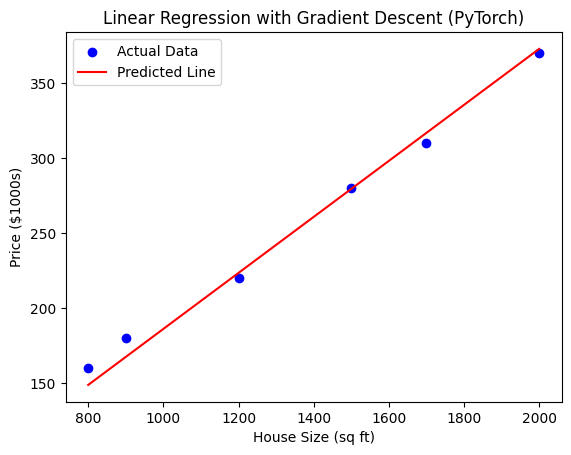

In [12]:
# Plot original data points
plt.scatter(house_size.numpy(), house_price.numpy(), label="Actual Data", color='blue')

# Plot regression line
predicted_prices = model(house_size).detach().numpy()
plt.plot(house_size.numpy(), predicted_prices, label="Predicted Line", color='red')

plt.xlabel("House Size (sq ft)")
plt.ylabel("Price ($1000s)")
plt.title("Linear Regression with Gradient Descent (PyTorch)")
plt.legend()
plt.show()

## **8️⃣ Adam vs. SGD**  
We've extensively described the many benefits of Adam of SGD in the lecture, time to compare them in practice.
Generate some training data and train the model using both methods.
Plot the evolution of the loss for both methods.


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate synthetic data
torch.manual_seed(42)
X = torch.randn(1000, 1)  # 100 samples, 1 feature
y = 3 * X + 2 + 0.2 * torch.randn(1000, 1)  # Linear function with noise

# Create two models (one for each optimizer)
model_adam = LinearRegressionModel()
model_sgd = LinearRegressionModel()

# Define loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define two optimizers
optimizer_adam = optim.Adam(model_adam.parameters(), lr=learning_rate)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=learning_rate)

# Training settings
epochs = 10
loss_adam, loss_sgd = [], []

# Training loop
for epoch in range(epochs):
    # -------- Train with Adam --------
    optimizer_adam.zero_grad()
    y_pred_adam = model_adam(house_size)
    loss_a = criterion(y_pred_adam, house_price)
    loss_a.backward()
    optimizer_adam.step()
    loss_adam.append(loss_a.item())

    # -------- Train with SGD --------
    optimizer_sgd.zero_grad()
    y_pred_sgd = model_sgd(house_size)
    loss_s = criterion(y_pred_sgd, house_price)
    loss_s.backward()
    optimizer_sgd.step()
    loss_sgd.append(loss_s.item())

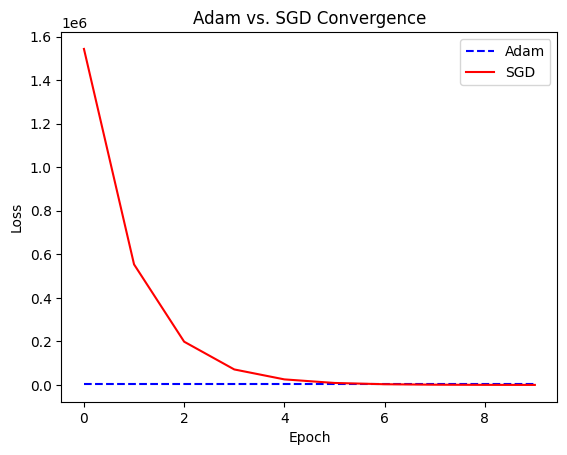

In [14]:
# Plot the loss curves
plt.plot(loss_adam, label="Adam", linestyle="--", color="blue")
plt.plot(loss_sgd, label="SGD", linestyle="-", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Adam vs. SGD Convergence")
plt.legend()
plt.show()

We notice for this very simple exercise that ADAM delivers much faster convergence of the loss function.

## **Conclusion 🎯**  

Using **gradient descent and PyTorch's `autograd`**, we successfully trained a **linear regression model** to predict house prices based on size. The **automatic differentiation** feature of PyTorch made computing gradients straightforward, avoiding the need for manual gradient calculations.  

**Key Takeaways:**  
✅ We used **PyTorch’s `autograd`** to compute gradients automatically.  
✅ The model parameters (\(w, b\)) were updated iteratively using **gradient descent**.  
✅ The **loss function (MSE)** decreased over time, improving the model's accuracy.  
✅ The trained model provides a **linear estimate of house prices**, which can be used for **real estate predictions**.  
✅ We usually use Adam over SGD in practice because it's much faster (we'll explore further this comparison over the next classes)

This is the **foundation** of how **deep learning models learn**—by **iteratively optimizing** a loss function using **gradient descent**! 🚀